In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

class Stitcher:

    #拼接函数
    def stitch(self, images, ratio=0.75, reprojThresh=4.0,showMatches=False):
        #获取输入图片
        (imageB, imageA) = images
        #检测 A、B 图片的 SIFT 关键特征点，并计算特征描述子
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)

        # 匹配两张图片的所有特征点，返回匹配结果
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)           

        # 如果返回结果为空，没有匹配成功的特征点，退出算法
        if M is None:
            return None

        # 否则，提取匹配结果
        # H是3x3视角变换矩阵      
        (matches, H, status) = M
        # 将图片A进行视角变换，result是变换后图片
        result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        # self.cv_show('result', result)
        # 将图片B传入result图片最左端
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
        # self.cv_show('result', result)
        # 检测是否需要显示图片匹配
        if showMatches:
            # 生成匹配图片
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            # 返回结果
            return (result, vis)

        # 返回匹配结果
        return result
    
    def cv_show(self,name,img):
        cv2.imshow(name, img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.waitKey(1)

    def detectAndDescribe(self, image):
        # 将彩色图片转换成灰度图
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 建立 SIFT 生成器
        descriptor = cv2.xfeatures2d.SIFT_create()
        # 检测 SIFT 特征点，并计算描述子
        (kps, features) = descriptor.detectAndCompute(image, None)

        # 将结果转换成 NumPy 数组
        kps = np.float32([kp.pt for kp in kps])

        # 返回特征点集，及对应的描述特征
        return (kps, features)

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # 建立暴力匹配器
        matcher = cv2.BFMatcher()
  
        # 使用 KNN 检测来自 A、B 图的SIFT特征匹配对，K=2
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)

        matches = []
        for m in rawMatches:
            # 当最近距离跟次近距离的比值小于 ratio 值时，保留此匹配对
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            # 存储两个点在 featuresA, featuresB 中的索引值
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # 当筛选后的匹配对大于 4 时，计算视角变换矩阵
        if len(matches) > 4:
            # 获取匹配对的点坐标
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # 计算视角变换矩阵
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

            # 返回结果
            return (matches, H, status)

        # 如果匹配对小于4时，返回None
        return None

    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # 初始化可视化图片，将A、B图左右连接到一起
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # 联合遍历，画出匹配对
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # 当点对匹配成功时，画到可视化图上
            if s == 1:
                # 画出匹配对
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # 返回可视化结果
        return vis

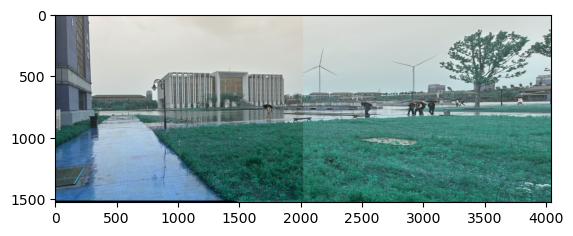

In [8]:
import cv2

# 读取拼接图片
imageA = cv2.imread("Picture/pic1.png")
imageB = cv2.imread("Picture/pic2.png")

# 把图片拼接成全景图
stitcher = Stitcher()  # 实例化 Stitcher 对象
(result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)

# 显示所有图片
plt.imshow(imageA)
plt.imshow(imageB)
plt.imshow(result)
# cv2.imshow("Image A", imageA)
# cv2.imshow("Image B", imageB)
# cv2.imshow("Keypoint Matches", vis)
# cv2.imshow("Result", result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.waitKey(1)

In [11]:
def plt_show(img,title):
    b,g,r = cv2.split(img)			#分别提取B、G、R通道
    img_new1 = cv2.merge([r,g,b])	#重新组合为R、G、B
    plt.xticks([]), plt.yticks([]) # 隐藏x和y轴
    plt.imshow(img_new1)
    plt.title(title)

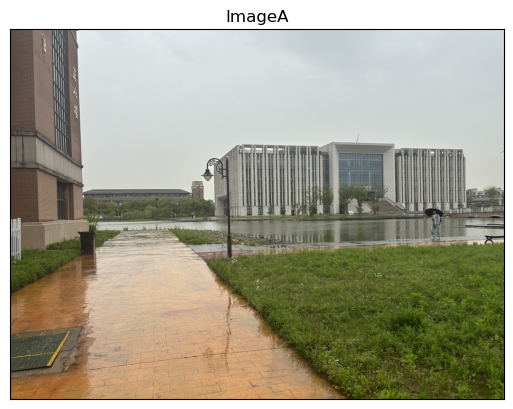

In [13]:
plt_show(imageA,"ImageA")

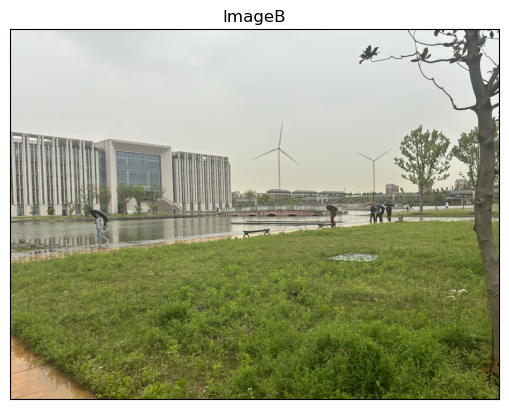

In [16]:
plt_show(imageB,"ImageB")

In [ ]:
plt_show(result,"ImageA")